In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from datetime import datetime

%matplotlib inline

In [2]:
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

from keras_facenet import FaceNet
embedder = FaceNet()

In [3]:
data_pointer = np.load("train_128x128_1_of_4.npz")
print(data_pointer.files)

['train']


In [4]:
this_data = data_pointer["train"]

(21686, 128, 128, 3)


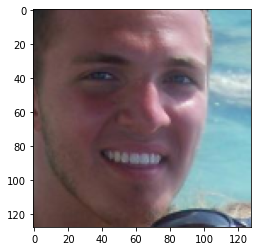

In [5]:
print(this_data.shape)
plt.imshow(this_data[3, :, :, ::-1]/256)

In [6]:
start = datetime.now()
embeddings = embedder.embeddings(this_data[:1000, :, :, ::-1]/256)
print(f"This took: {datetime.now()-start}")

This took: 0:01:25.708879


In [7]:
print(embeddings.shape)

(1000, 512)


In [8]:
labels = np.load("labels.npz")["train"][0:1000]
print(labels.shape)

(1000, 20)


In [9]:
valid_embeddings = embedder.embeddings(this_data[1000:1200, :, :, ::-1]/256)
valid_labels = np.load("labels.npz")["train"][1000:1200]

In [10]:
inputs = keras.Input(shape=(embeddings.shape[1],))
x = keras.layers.Dense(128, activation='relu')(inputs)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)

x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.1)(x)

outputs = keras.layers.Dense(labels.shape[1], activation="linear")(x)
model = keras.Model(inputs = inputs, outputs = outputs, name="OpenFace_extension")

model.summary()

Model: "OpenFace_extension"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)         

In [11]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

In [12]:
batch_size = 32


train_data = tf.data.Dataset.from_tensor_slices((embeddings, labels))
val_data = tf.data.Dataset.from_tensor_slices((valid_embeddings, valid_labels))
train_data = train_data.batch(batch_size)

In [14]:
model.fit(train_data, validation_data=val_data,epochs=3)

ValueError: in converted code:

    D:\Programs\Anaconda\envs\tf-gpu\lib\site-packages\tensorflow_core\python\keras\engine\training_v2.py:677 map_fn
        batch_size=None)
    D:\Programs\Anaconda\envs\tf-gpu\lib\site-packages\tensorflow_core\python\keras\engine\training.py:2410 _standardize_tensors
        exception_prefix='input')
    D:\Programs\Anaconda\envs\tf-gpu\lib\site-packages\tensorflow_core\python\keras\engine\training_utils.py:582 standardize_input_data
        str(data_shape))

    ValueError: Error when checking input: expected input_2 to have shape (512,) but got array with shape (1,)
